In [2]:
### variable con volores enteros
## id_observacion, gasto*, fecha_captura_informacion*, fuente*, nombre_campania*, impresiones* no presentan valores nulos
## cuando el arte no se publica (id_anuncio*, id_conjunto_anuncios*, id_campania*) al 42%, fecha_publicacion_anuncio*, formato* presentan valores nulos
## objetivo_campania* presenta valores nulos al 24%, tomando en cuenta las artes que no se publicaron presenta valores nulos al 57%
## visitas_al_50*, visitas_al_75*, visitas_al100* presentan valores nulos al 18%, tomando en cuenta las artes que no se publicaron presenta valores nulos al 48%

In [3]:
# cuando el anuncio no publicado pero no tiene interacciones
# - no se tienen registros en las visitas pero hay un registro outlier
# - las impresiones son muy variables
# - normal la captura de informacion, aunque la media es setiembre 
# - los gatos son mas altos
# - fuente "direct" es la mas relevante, pero no aparecen "instagram" y "teads"
# - objetivo_campania presenta valores menos "event responses"
# - formato no presenta valores (nan) 
# - nombre_camapania aparecen todos menos "equity", "fin de ano" y "gastronomia promo"

# ###### Posiblemente sea un error en el sistema que sucedió en el mes de agosto ######
# cuando el anuncio no publicado pero si tiene interacciones
# - visitas no presenta valores (nan)
# - la impresiones no son muy variables
# - la media del mes de captura de informacion es agosto 8 (min, max,25%, 50%, 75%)
# - los gastos son bajos
# - fuente "direct" es la unica que aparece
# - objetivo_campania no presenta valores (nan)
# - formato no presenta valores (nan)
# - nombre_campania "gastronomy" es la unica que aparece

## Importar Librerias Estandar

In [4]:
import pandas as pd
import json
import datetime as dt
import numpy as np
import re
import warnings as w
w.filterwarnings('ignore')

## Definir Funciones

In [5]:
def get_train():
    #method: cargar la data de entrenamiento
    with open('../data/train.json', mode='r') as f:
        data = json.load(f)
    list_dict_data = []
    for i in data:
        dict_data = {}
        for j in i:
            dict_data[list(j.keys())[0]] = j[list(j.keys())[0]]
        list_dict_data.append(dict_data)
    df = pd.DataFrame(list_dict_data)
    return df

def get_normalize_columns(df):
    ##method: normalizar los nombres de columnas
    df.columns = [i.strip().lower().translate(str.maketrans('áéíóúü','aeiouu')) for i in df.columns]
    return df

def get_feature_engineering(df):
    ##method: aplicar feature engineering
    df.replace({None:np.nan}, inplace=True)    
    df.sort_values(['id_anuncio','fecha_captura_informacion'], ascending = True, inplace = True)
    ### manejo de valores repetivos
    df['nombre_campania'] = df['nombre_campania'].replace({'GASTRONOMIA':'GASTRONOMY','GASTRONOMÃ�A':'GASTRONOMY','GASTRONOMÍA':'GASTRONOMY'})
    ### convertir a datetime las fecha de publicacion y captura
    df['fecha_publicacion_anuncio'] = df['fecha_publicacion_anuncio'].apply(lambda x: dt.datetime.strptime(x, '%a, %d %b %Y 00:00:00 GMT') if str(x)!='nan' else np.nan)
    df['fecha_captura_informacion'] = df['fecha_captura_informacion'].apply(lambda x: dt.datetime.strptime(x, '%a, %d %b %Y 00:00:00 GMT') if str(x)!='nan' else np.nan)

    ### calucar la diferencia entra le fecha captura de informacion y la fecha de publicacion del anuncio
    df['duracion_anuncio_dias'] = (df['fecha_captura_informacion'] - df['fecha_publicacion_anuncio']).dt.days

    ### extraer la diferencia entra la captura de información con la anterior captura de informacion del anuncio
    grouped = df.groupby('id_anuncio')
    diff = lambda x: x['fecha_captura_informacion'].replace(0, np.NaN).diff() 
    df["diff_captura_anterior"] = grouped.apply(diff).reset_index(0, drop = True).dt.days
    df['diff_captura_anterior'].fillna(df['duracion_anuncio_dias'], inplace = True)
    
    # bins = [0, 7, 14, 21, 28, 35, 42, 49, float("inf")]
    # df['duracion_anuncio_semanas'] = pd.cut(df.duracion_anuncio_dias, bins).cat.codes + 1
    # df['duracion_anuncio_semanas'] = df['duracion_anuncio_semanas'].replace({0:np.nan})

    ### obtener los dias y meses de las fechas de publicacion y captura
    df['fecha_captura_informacion_day'] = df['fecha_captura_informacion'].apply(lambda x: x.day)
    df['fecha_captura_informacion_month'] = df['fecha_captura_informacion'].apply(lambda x: x.month)
    df['fecha_publicacion_anuncio_day'] = df['fecha_publicacion_anuncio'].apply(lambda x: x.day)
    df['fecha_publicacion_anuncio_month'] = df['fecha_publicacion_anuncio'].apply(lambda x: x.month)    
    
    # df = df[df.id_anuncio.astype(str)=='nan'].copy()
    # df['objetivo_campania'] =  df['objetivo_campania'].replace({np.nan: df['objetivo_campania'].value_counts().index[0]})
    
    ## imputar visitas cuando el anuncio se haya publicado
    mask = df['id_anuncio'].astype(str)!='nan'
    df.loc[mask,'visitas_al100'] = df[mask]['visitas_al100'].replace({np.nan:df['visitas_al100'].median()})
    df.loc[mask,'visitas_al_75'] = df[mask]['visitas_al_75'].replace({np.nan:df['visitas_al_75'].median()})
    df.loc[mask,'visitas_al_50'] = df[mask]['visitas_al_50'].replace({np.nan:df['visitas_al_50'].median()})       
    return df

def get_normalize_values(x):
    ##method: normalizar los valores de las variables categoricas
    x = x.lower()
    x = x.strip()
    x = re.sub(r'\s+',' ', x)
    x = x.translate(str.maketrans('áéíóúü','aeiouu'))
    return x

def get_one_hot(df, feature):
    ##method: aplicar one_hot_enconding a las variables categoricas
    df[feature] = df[feature].apply(lambda x:get_normalize_values(x) if type(x)==str else np.nan)
    one_hot = pd.get_dummies(df[feature])
    one_hot.columns = [feature+'_'+ i for i in one_hot.columns]
    return one_hot

def get_feature_selection(fi):
    ##method: encontar las variables con una importancia acumulativa al 99% y las variables con zero importancia
    zero_importance = fi[fi==0]
    aux = fi[fi>0].sort_values(ascending=False)
    keep_columns = []
    count = 0
    for feature,values in zip(aux.index, aux.values):
        count+=values
        if count<=0.99:
            keep_columns.append(feature)
            
    print(f'total de variables : {len(fi)}')
    print(f'variables con importancia acumulada al 99% : {len(keep_columns)}')
    print(f'variables con zero importancia : {len(zero_importance)}')
    return keep_columns, zero_importance

## Cargar Train y Test 

In [6]:
train = get_train()
test = pd.read_csv('../data/Data_Validacion.csv',sep=';')
# test_index = list(test.ID_observacion)

## Procesamiento de la data (Train, Test, Target)

In [7]:
var_categ = ['fuente','objetivo_campania','formato','nombre_campania']
train = get_normalize_columns(train)
test = get_normalize_columns(test)
train = get_feature_engineering(train)
test = get_feature_engineering(test)

### aplicar one_hot_encoding a las features categoricas
list_one_hot_train = []
for i in var_categ:
    df = get_one_hot(train, i)
    list_one_hot_train.append(df)
one_hot_train = pd.concat(list_one_hot_train,axis=1)
train = train.join(one_hot_train)

train.set_index('id_observacion', inplace=True)
train.drop(['id_conjunto_anuncios', 'id_campania','id_anuncio',\
            'moneda', 'country', 'brand','fecha_publicacion_anuncio','fecha_captura_informacion'], axis=1, inplace=True)

list_one_hot_test = []
for i in var_categ:
    df = get_one_hot(test, i)
    list_one_hot_test.append(df)
one_hot_test = pd.concat(list_one_hot_test,axis=1)    
test = test.join(one_hot_test)

test.set_index('id_observacion', inplace=True)
test.drop(['id_conjunto_anuncios', 'id_campania','id_anuncio',\
            'moneda', 'country', 'brand','fecha_publicacion_anuncio','fecha_captura_informacion'], axis=1, inplace=True)

### reemplazar el valor de la variable gasto
test['gasto'] = test['gasto'].replace({'40000%':40000})
test['gasto'] = test['gasto'].astype(float)
y_train = train[['interacciones']].rename(columns = {'interacciones':'target'})

In [8]:
### aplicar mean encoding a las variables categoricas
mean_encoding_fuente = train.groupby('fuente').interacciones.mean().to_dict()
mean_encoding_objetivo_campania = train.groupby('objetivo_campania').interacciones.mean().to_dict()
mean_encoding_formato = train.groupby('formato').interacciones.mean().to_dict()
mean_encoding_nombre_campania = train.groupby('nombre_campania').interacciones.mean().to_dict()

train['mean_encoding_fuente'] = train['fuente'].replace(mean_encoding_fuente)
test['mean_encoding_fuente'] = test['fuente'].replace(mean_encoding_fuente)

train['mean_encoding_objetivo_campania'] = train['objetivo_campania'].replace(mean_encoding_objetivo_campania)
test['mean_encoding_objetivo_campania'] = test['objetivo_campania'].replace(mean_encoding_objetivo_campania)

train['mean_encoding_formato'] = train['formato'].replace(mean_encoding_formato)
test['mean_encoding_formato'] = test['formato'].replace(mean_encoding_formato)

train['mean_encoding_nombre_campania'] = train['nombre_campania'].replace(mean_encoding_nombre_campania)
test['mean_encoding_nombre_campania'] = test['nombre_campania'].replace(mean_encoding_nombre_campania)

train.drop(var_categ, axis=1, inplace=True)
test.drop(var_categ, axis=1, inplace=True)

## Uniformizar las variables en Train y Test

In [9]:
try:
    features_importances_rec = features_importances[features_importances>0]
    train = train[features_importances_rec.index]
    test = test[features_importances_rec.index]
    print('entrando a feature_importances', train.shape, test.shape)
except:
    keep_columns = set(test.columns).intersection(set(train.columns))
    train = train[keep_columns]
    test = test[keep_columns]
    print('normal', train.shape, test.shape)

normal (5562, 50) (2378, 50)


In [10]:
# train = train.replace(np.NaN,0)
# test = test.replace(np.NaN,0)

## Cross Validation

In [11]:
# from sklearn.model_selection import KFold
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import ParameterGrid
# params = ParameterGrid({"n_estimators":[250, 500, 750, 1000],"max_depth":[6, 9, -1]})
# # test_probs = []
# # train_probs = []
# # fi = []
# folds = [train.index[t] for t, v in KFold(5).split(train)]
# result_tunning = {"score":999999,"param":""}
# for param in params:
#     test_probs = []
#     train_probs = []
#     for i, idx in enumerate(folds):
#         # print("*"*10, i, "*"*10)
#         Xt = train.loc[idx]
#         yt = y_train.loc[Xt.index].target

#         Xv = train.drop(Xt.index)
#         yv = y_train.loc[Xv.index].target

#         learner = CatBoostRegressor(n_estimators=1000, eval_metric = 'RMSE', random_state=42, )
#         learner.fit(Xt, yt,  early_stopping_rounds=10, 
#                     eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
        
#         test_probs.append(pd.Series(learner.predict(test), index=test.index, name="fold_" + str(i)))
#         train_probs.append(pd.Series(learner.predict(Xv), index=Xv.index, name="probs"))
#         # fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

#     test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
#     test_probs = test_probs.apply(lambda x: 0 if x<0 else x)

#     train_probs = pd.concat(train_probs)
#     train_probs = train_probs.apply(lambda x: 0 if x<0 else x)

#     # fi = pd.concat(fi, axis=1).mean(axis=1)
#     #print('rmse', np.sqrt(np.sum(( train_probs.loc[train.index] - y_train.loc[train.index].target)**2)/len(train)))
#     score = mean_squared_error(y_train.loc[train.index].target, train_probs.loc[train.index], squared=False)
#     print('param', param, score)
#     if score < result_tunning["score"]:
#         result_tunning["score"] = score
#         result_tunning["param"] = param
# print(result_tunning)

## Entrenamiento de la Data 

In [12]:
from lightgbm import LGBMRegressor
# learner = LGBMRegressor(n_estimators=1000,  random_state=42, **result_tunning["param"]) 
learner = LGBMRegressor(n_estimators=1000,  random_state=42)
learner.fit(train, y_train, eval_metric="rmse")

LGBMRegressor(n_estimators=1000, random_state=42)

In [13]:
from catboost import CatBoostRegressor
# learner_catboost = CatBoostRegressor(n_estimators=1000, eval_metric = 'RMSE', max_depth = 6, random_state=42)
learner_catboost = CatBoostRegressor(n_estimators=1000, eval_metric = 'RMSE', random_state=42)
learner_catboost.fit(train, y_train, verbose = 100)

Learning rate set to 0.053694
0:	learn: 1729.5541935	total: 142ms	remaining: 2m 22s
100:	learn: 574.1632600	total: 499ms	remaining: 4.44s
200:	learn: 435.2338008	total: 766ms	remaining: 3.05s
300:	learn: 356.6244020	total: 995ms	remaining: 2.31s
400:	learn: 310.2477861	total: 1.33s	remaining: 1.99s
500:	learn: 268.1045959	total: 1.74s	remaining: 1.73s
600:	learn: 232.8948194	total: 2.19s	remaining: 1.45s
700:	learn: 208.0183185	total: 2.61s	remaining: 1.11s
800:	learn: 184.8730215	total: 3.05s	remaining: 758ms
900:	learn: 168.0595779	total: 3.48s	remaining: 382ms
999:	learn: 157.4678402	total: 3.94s	remaining: 0us


## Visualización del la Importancia de Variables

In [14]:
features_importances = pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
_, _ = get_feature_selection(features_importances)

total de variables : 50
variables con importancia acumulada al 99% : 23
variables con zero importancia : 11


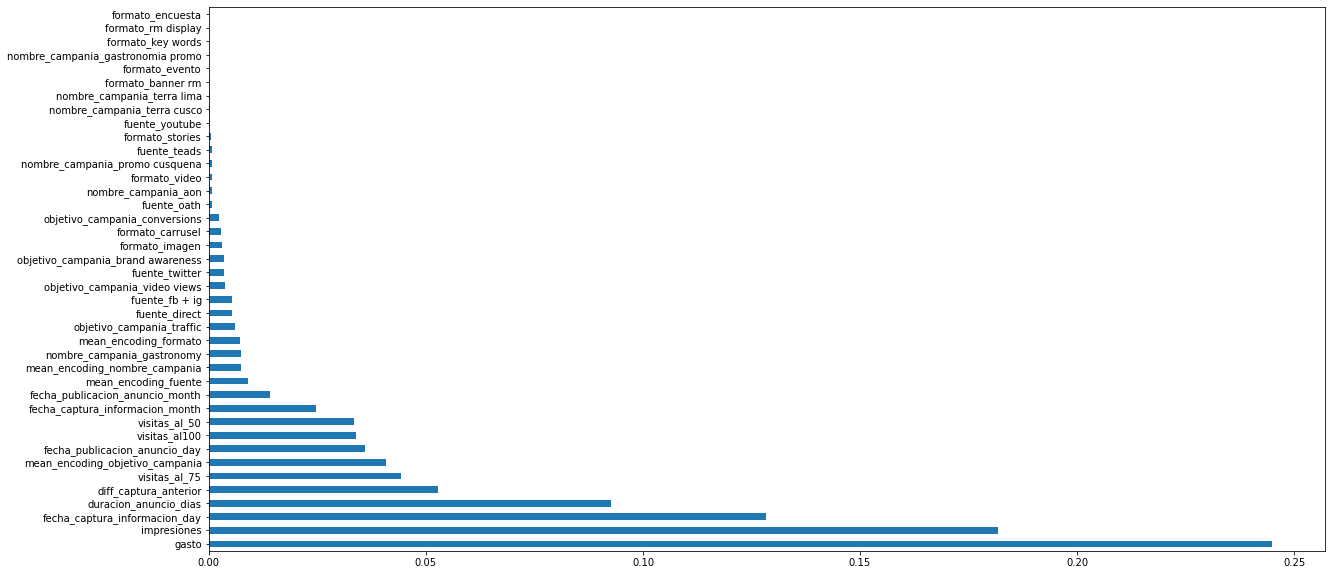

In [15]:
%matplotlib inline
features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

In [16]:
features_importances = pd.Series(learner_catboost.feature_importances_ / learner_catboost.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
_, _ = get_feature_selection(features_importances)

total de variables : 50
variables con importancia acumulada al 99% : 23
variables con zero importancia : 3


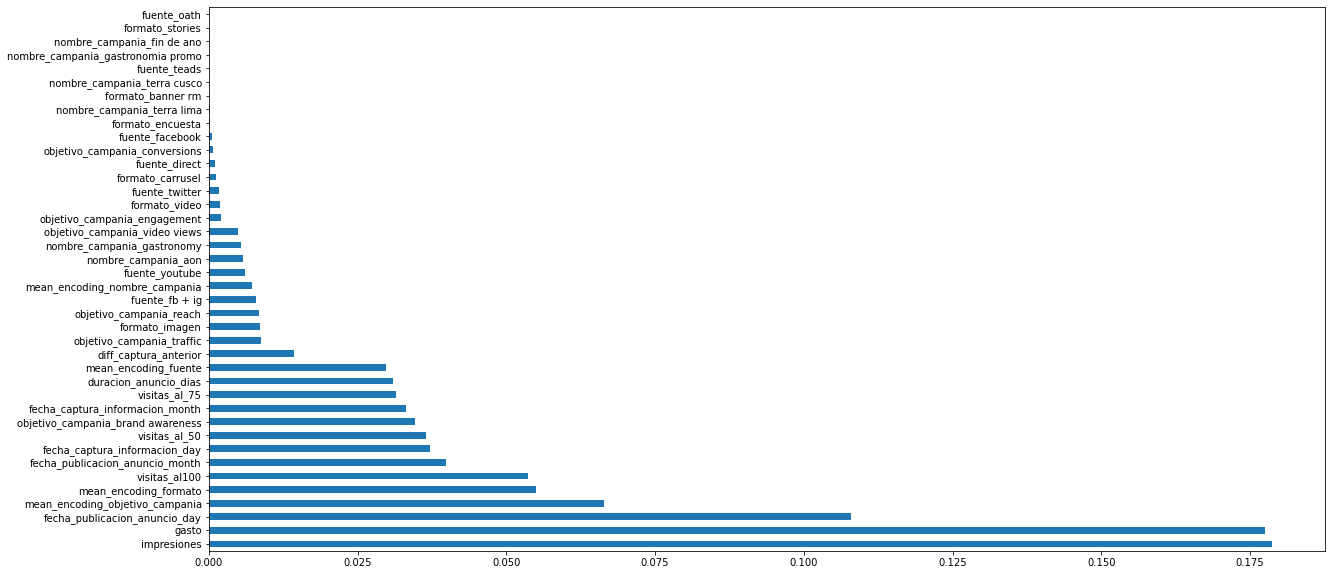

In [17]:
%matplotlib inline
features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

## Submit

In [18]:
test_submit = test.copy()
# test_submit['INTERACCIONES'] = learner.predict(test_submit)
test_submit['INTERACCIONES'] = (learner.predict(test_submit) + learner_catboost.predict(test_submit))/2
# test_submit['INTERACCIONES'] =  learner_catboost.predict(test_submit)
mask = test_submit['INTERACCIONES']<=0
test_submit.loc[mask,'INTERACCIONES'] = 0

In [19]:
test_submit = test_submit.reset_index()
test_submit = test_submit[['id_observacion','INTERACCIONES']]
test_submit.columns = ['ID_OBSERVACION', 'INTERACCIONES']
test_submit

,ID_OBSERVACION,INTERACCIONES
0,ID_V_001297,0.000000
1,ID_V_001317,617.118368
2,ID_V_001305,96.557721
3,ID_V_001312,0.000000
4,ID_V_001324,67.412992
...,...,...
2373,ID_V_002241,0.000000
2374,ID_V_001861,175.066769
2375,ID_V_001864,2817.213230
2376,ID_V_001865,3303.892812


In [20]:
test_submit.to_csv('../results/test_final.csv', index=False)

In [21]:
# test_submit_ = pd.DataFrame({'ID_OBSERVACION':test_index, 'INTERACCIONES':0})
# test_submit_.set_index('ID_OBSERVACION', inplace=True)
# test_submit_.loc[test_submit.ID_OBSERVACION, 'INTERACCIONES'] = test_submit.set_index('ID_OBSERVACION')['INTERACCIONES']
# test_submit_

In [22]:
# test_submit_.to_csv('../results/test_final.csv')